In [1]:
import pandas as pd 
import numpy as np 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
from  sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

%matplotlib inline

In [2]:
df = pd.read_csv('AER_credit_card_data.csv')
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [3]:
df['card'].value_counts()

yes    1023
no      296
Name: card, dtype: int64

In [4]:
# check missingы in target
df['card'].isna().value_counts()

False    1319
Name: card, dtype: int64

In [5]:
dict_target = {'yes' : 1, 'no' : 0}
df['card'] = df['card'].map(dict_target)

In [6]:
# смотрим на полученные
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [7]:
# Split the dataset into 3 parts: train/validation/test 
# with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1
df_train_all, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_valid = train_test_split(df_train_all, test_size=0.25, random_state=1)

In [8]:
print(df_train.shape, df_valid.shape, df_test.shape)

(791, 12) (264, 12) (264, 12)


In [9]:
# columns and types 
df_for_estimate = df.select_dtypes(include=['float64', 'int64'])
df_for_estimate.head()

,card,reports,age,income,share,expenditure,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,2,64,1,5


In [10]:
list_features = []
for col in df_for_estimate.columns[1:]:
    roc_auc = roc_auc_score(df_for_estimate['card'], df_for_estimate[col])
    if roc_auc < 0.5:
        roc_auc = roc_auc_score(df_for_estimate['card'], -df_for_estimate[col])
    list_features.append((col, roc_auc))
sorted(list_features, key = lambda x: -x[1])

[('share', 0.9898054212570342),
 ('expenditure', 0.9897360703812317),
 ('reports', 0.7178013790917016),
 ('income', 0.5888896594541755),
 ('active', 0.5824680985971309),
 ('majorcards', 0.5499111648305197),
 ('dependents', 0.5257721064172676),
 ('months', 0.5178826186890704),
 ('age', 0.5013754590367494)]

In [11]:
need_columns = ["reports", "age", "income", "share", "expenditure",\
                "dependents", "months", "majorcards", "active", "owner", "selfemp"]

X_train = df_train[need_columns]
y_train = df_train['card']

X_valid = df_valid[need_columns]
y_valid = df_valid['card']

X_test = df_test[need_columns]
y_test = df_test['card']

In [12]:
# dict for count Vectorizer
train_dict = X_train[["owner", "selfemp"]].to_dict(orient='records') 
valid_dict = X_valid[["owner", "selfemp"]].to_dict(orient='records') 
test_dict = X_test[["owner", "selfemp"]].to_dict(orient='records') 

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_cat_train = dv.transform(train_dict)
X_cat_valid = dv.transform(valid_dict)
X_cat_test = dv.transform(test_dict)

df_cat_train = pd.DataFrame(data = X_cat_train, columns = dv.get_feature_names(), index = X_train.index)
df_cat_valid = pd.DataFrame(data = X_cat_valid, columns = dv.get_feature_names(), index = X_valid.index)
df_cat_test = pd.DataFrame(data = X_cat_test, columns = dv.get_feature_names(), index = X_test.index)

In [13]:
X_train_ = pd.concat([X_train, df_cat_train], axis = 1)
X_valid_ = pd.concat([X_valid, df_cat_valid], axis = 1)
X_test_ = pd.concat([X_test, df_cat_test], axis = 1)

In [14]:
X_train_.drop(columns = ['owner', 'selfemp', 'owner=yes', 'selfemp=yes'], axis = 1, inplace = True)
X_valid_.drop(columns = ['owner', 'selfemp', 'owner=yes', 'selfemp=yes'], axis = 1, inplace = True)
X_test_.drop(columns = ['owner', 'selfemp', 'owner=yes', 'selfemp=yes'], axis = 1, inplace = True)

In [15]:
# we use different range of data and it is bad...
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [16]:
pred = model.predict_proba(X_valid_)[:, 1]

print(round( roc_auc_score(y_valid, pred), 3))

0.995


In [17]:
# recall and precision 
# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
# For each threshold, compute precision and recall
# Plot them
recall_list = []
precision_list = []
thresholds = [0.01 * i for i in range(101)]
for tr in thresholds:
    recall_list.append(recall_score(y_valid, np.where(pred >= tr, 1, 0)))
    precision_list.append(precision_score(y_valid, np.where(pred >= tr, 1, 0)))
    

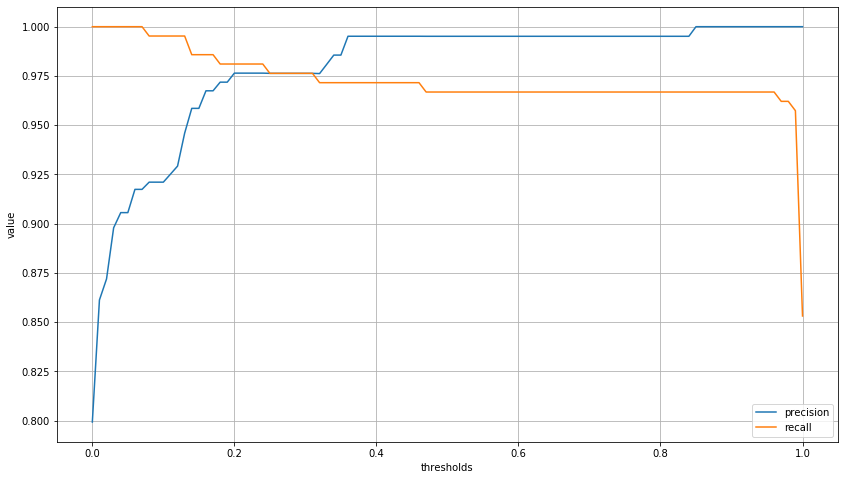

In [18]:
# plot graphs 
plt.figure(figsize=(14,8));
plt.plot(thresholds, precision_list, label = 'precision');
plt.plot(thresholds, recall_list, label = 'recall');

plt.legend();
plt.xlabel('thresholds');
plt.ylabel('value');
plt.grid(True);

In [19]:
f1_list = []

for p,r in zip(precision_list, recall_list):
    f1_list.append(2*p*r/(p+r))

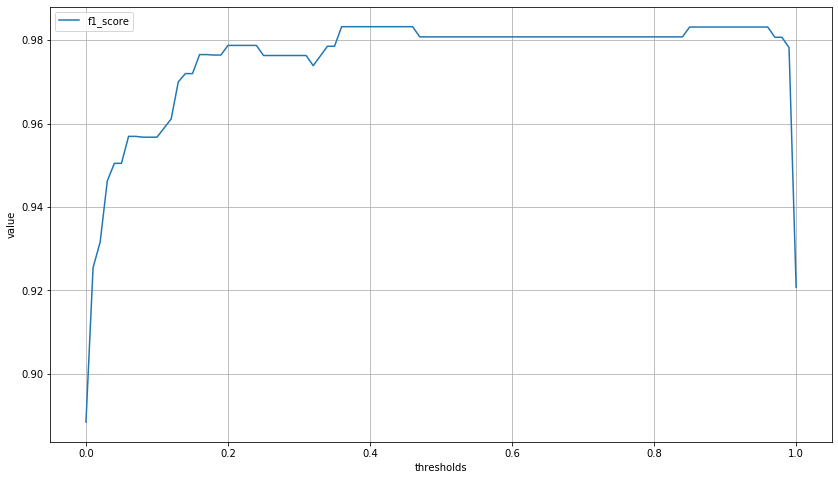

In [20]:
# plot graphs 
plt.figure(figsize=(14,8));
plt.plot(thresholds, f1_list, label = 'f1_score');

plt.legend();
plt.xlabel('thresholds');
plt.ylabel('value');
plt.grid(True);

In [35]:
def train_function(df_train_, target = 'card'): 
    dv =DictVectorizer(sparse = False)
    
    X_tr_dict = df_train_.drop([target], axis = 1).to_dict(orient='records') 
    dv.fit(X_tr_dict)
    X_tr = dv.transform(X_tr_dict)
    
    lg = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    lg.fit(X_tr, df_train_[target])
    
    return dv, lg
    

In [36]:
def valid_function(df_test, dv, model, target = 'card'):
    X_test_dict = df_test.drop([target], axis = 1).to_dict(orient='records')
    X_tst = dv.transform(X_test_dict)
    predict = model.predict_proba(X_tst)[:, 1]
    
    return predict, df_test['card']

In [37]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

In [38]:
roc_list = []
for train_idx, valid_idx in kf.split(df_train_all):
    train_d = df_train_all.iloc[train_idx]
    valid_d = df_train_all.iloc[valid_idx]
    
    # 
    dv_, lr = train_function(train_d, target = 'card')
    pred, trgt = valid_function(valid_d, dv_, lr, target= 'card')
    
    roc_list.append(roc_auc_score(trgt, pred))
    

In [40]:
np.std(roc_list)

0.0027434713804377724

In [ ]:
# Now let's use 5-Fold cross-validation to find the best parameter C
# Iterate over the following C values: [0.01, 0.1, 1, 10]
# Initialize KFold with the same parameters as previously
# Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
# Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [42]:
def train_function_C(df_train_, target = 'card', C_ =1): 
    dv =DictVectorizer(sparse = False)
    
    X_tr_dict = df_train_.drop([target], axis = 1).to_dict(orient='records') 
    dv.fit(X_tr_dict)
    X_tr = dv.transform(X_tr_dict)
    
    lg = LogisticRegression(solver='liblinear', C=C_, max_iter=1000)
    lg.fit(X_tr, df_train_[target])
    
    return dv, lg
    

In [45]:
for c in [0.01, 0.1, 1, 10]:  
    roc_list = []
    for train_idx, valid_idx in kf.split(df_train_all):
        train_d = df_train_all.iloc[train_idx]
        valid_d = df_train_all.iloc[valid_idx]

        # 
        dv_, lr = train_function_C(train_d, target = 'card', C_ = c)
        pred, trgt = valid_function(valid_d, dv_, lr, target= 'card')

        roc_list.append(roc_auc_score(trgt, pred))
    print('C = {} : '.format(c), round(np.mean(roc_list), 3), '+-' , round(np.std(roc_list), 3))

C = 0.01 :  0.992 +- 0.006
C = 0.1 :  0.995 +- 0.004
C = 1 :  0.996 +- 0.003
C = 10 :  0.996 +- 0.003
